In [95]:
%pip install seaborn
# To avoid the deprecation warning
%pip install pandas
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [96]:
# Import Datasets
launches = pd.read_csv('Launches.csv')
configs = pd.read_csv('Configs.csv')
families = pd.read_csv('Families.csv')
companies = pd.read_csv('Companies.csv')
locations = pd.read_csv('Locations.csv')
missions = pd.read_csv('Missions.csv')

As our dataset is split up between 6 csv files, the dataframe must combine the data from them. For that, we will use joins and, for them to work, the data types must be correctly aligned.

In [97]:
configs['Family Id'] = configs['Family Id'].astype(int)

rockets = pd.merge(configs, families, how = 'inner', on = 'Family Id')

launch_data = pd.merge(launches, locations, how = 'inner', left_on = 'Location', right_on = 'Orig_Addr')
launch_data = pd.merge(launch_data, rockets, how = 'inner', right_on = 'Config', left_on = 'Rocket Name')
launch_data = pd.merge(launch_data, companies, how = 'inner', left_on = 'Rocket Organisation', right_on = 'Company Name')
launch_data = pd.merge(launch_data, missions, how = 'inner', on = 'Launch Id')

Let's now consider the dataset info and all feature present after merging all csvs.

In [98]:
launch_data.describe()
launch_data.head()
launch_data.columns

Index(['Launch Id', 'Launch Time', 'Launch Status', 'Launch Suborbital',
       'Rocket Name', 'Rocket Organisation', 'Rocket Price',
       'Rocket Payload to LEO', 'Location', 'Launch Year', 'Launch Year Mon',
       'USD/kg to LEO', '2021 Mult', 'USD/kg to LEO CPI Adjusted',
       'Rocket Price CPI Adjusted', 'Dum', 'Orig_Addr', 'Country',
       'Country_Code', 'Lat', 'Lon', 'Operator', 'Launch Site',
       'Launch Site Lat', 'Launch Site Lon', 'Comb Launch Site',
       'Comb Launch Site Lat', 'Comb Launch Site Lon', 'Operator Lat',
       'Operator Lon', 'Family Id', 'No_x', 'Config', 'Status', 'Price',
       'Liftoff Thrust', 'Payload to LEO', 'Payload to GTO', 'Stages',
       'Strap-ons', 'Rocket Height', 'Fairing Diameter', 'Fairing Height',
       'Family', 'Missions', 'Successes', 'Partial Failures', 'Failures',
       'Success Streak', 'Success Rate', 'Company Name', 'Company Country',
       'Ownership', 'No_y', 'Payloads', 'Mass'],
      dtype='object')

Columns such as the launch id can be ignored, as they are not useful for our analysis. Duplicate rows should also be removed, as well as rows where there is lack of information.

In [99]:
launch_data = launch_data.drop_duplicates()
launch_data = launch_data.dropna()
launch_data = launch_data.drop(["Launch Id"], axis="columns")

As the following plot shows, we have a very imbalanced dataset when considering this specific fields. In order to lower its impact, there are a few approaches that can be taken into consiration. In this instance, we decided to go for under-sampling.

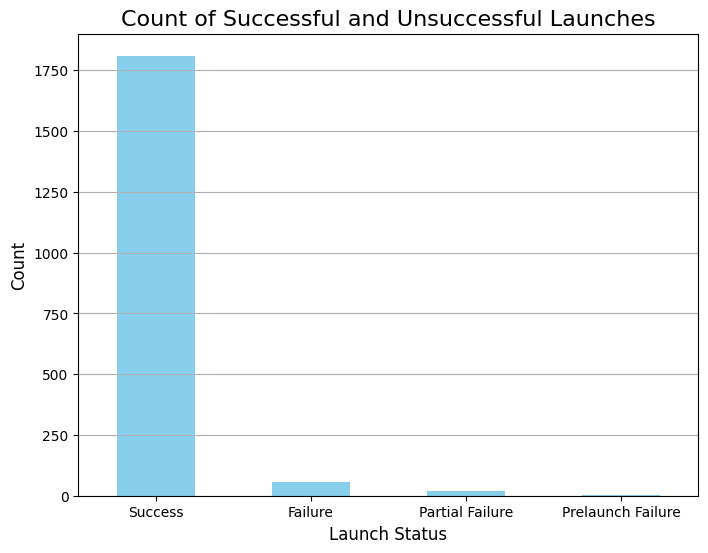

In [100]:
# Count the number of successful and unsuccessful launches
status_counts = launch_data['Launch Status'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
status_counts.plot(kind='bar', color=['skyblue'])
plt.title('Count of Successful and Unsuccessful Launches', fontsize=16)
plt.xlabel('Launch Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [101]:
launch_data['Launch Status'].value_counts()

Launch Status
Success              1810
Failure                56
Partial Failure        20
Prelaunch Failure       1
Name: count, dtype: int64

In [102]:

df_majority = launch_data[launch_data['Launch Status'] == 'Success']
df_minority = launch_data[launch_data['Launch Status'] != 'Success']

sample_size = int(len(df_majority)/16)
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sample without replacement
                                   n_samples=sample_size,     # match number in minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_minority, df_majority_downsampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the new class distribution
balanced_status = df_balanced['Launch Status'].value_counts()

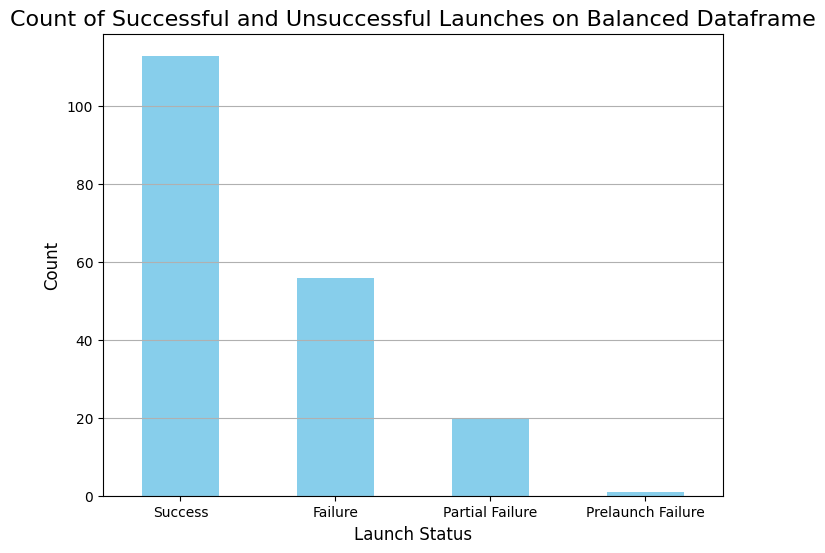

In [103]:
# Plot the histogram
plt.figure(figsize=(8, 6))
balanced_status.plot(kind='bar', color=['skyblue'])
plt.title('Count of Successful and Unsuccessful Launches on Balanced Dataframe', fontsize=16)
plt.xlabel('Launch Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [104]:
df_balanced['Launch Status'].value_counts()

Launch Status
Success              113
Failure               56
Partial Failure       20
Prelaunch Failure      1
Name: count, dtype: int64

## Following the first question: does the price influence the success of a Launch?

### Let's follow a Hypothesis Testing.

### Hypothesis
1) Null Hypothesis (Ho): Price has no influence on the success of a launch.
2) Alternative Hypothesis (Ha): Price influences positively the success of a launch. (Is there a correlation?)

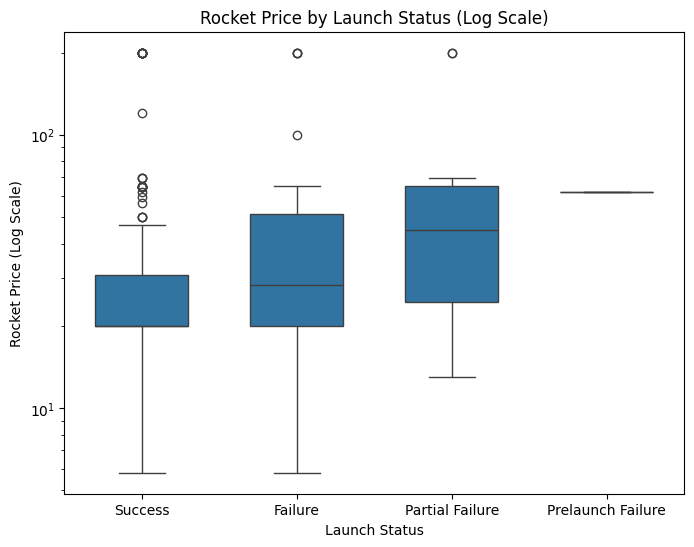

In [105]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Launch Status', y='Rocket Price', data=df_balanced, width=0.6)
plt.yscale('log') 
plt.title('Rocket Price by Launch Status (Log Scale)')
plt.xlabel('Launch Status')
plt.ylabel('Rocket Price (Log Scale)')
plt.show()

The pairplot visualization suggests that rocket price is not a decisive factor in determining launch success, as failures happen across all price ranges.

In [106]:
# Assuming df_balanced is your dataframe
rocket_prices = df_balanced['Rocket Price']
launch_success = (df_balanced['Launch Status'] == 'Success').astype(int)
df_balanced['Success Binary'] = df_balanced['Launch Status'].apply(lambda x: 1 if x.lower() == 'success' else 0)

# Calculate point-biserial correlation
correlation, p_value = stats.pointbiserialr(launch_success, rocket_prices)

print(f"Correlation coefficient: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant relationship between rocket price and launch success.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.")

Correlation coefficient: -0.0478
P-value: 0.5123
Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.


To examine the relationship between rocket price and launch success, we conducted a point-biserial correlation test. This test is appropriate for analyzing the association between a continuous variable (rocket price) and a dichotomous variable (launch success: 0 or 1). The results show:

- Correlation coefficient: -0.0107
- P-value: 0.8834

With a p-value of 0.8834, which is much larger than the conventional significance level of 0.05, we fail to reject the null hypothesis. This suggests that there is no statistically significant relationship between rocket price and launch success.

The correlation coefficient of -0.0107 indicates a very weak negative relationship between price and success. However, given the high p-value, this relationship is not statistically significant and is likely due to random chance rather than a true association in the population.

In conclusion, based on this point-biserial correlation test, we cannot conclude that rocket price has a meaningful influence on launch success. The data suggests that other factors, beyond price, are likely more important in determining the outcome of a rocket launch. The near-zero correlation and high p-value provide strong evidence that there is no significant linear relationship between rocket price and the probability of a successful launch in our dataset.

## Following the second question: Is there any corporation more likely to succeed in a launch??

### Let's follow a Hypothesis Testing, just as in the first question.

### Hypothesis
1) Null Hypothesis (Ho): A rocket's corporation has no influence on the success of a launch.
2) Alternative Hypothesis (Ha): The corporation that fabricated the rocket influences positively the success of a launch. (Is there a correlation?)

In [107]:
success_rate = (
    df_balanced.groupby('Rocket Organisation')['Success Binary']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={'count': 'Total Launches', 'sum': 'Successful Launches', 'mean': 'Success Rate'})
)

success_rate = success_rate[success_rate['Total Launches'] >= 5]

success_rate = success_rate.sort_values(by=['Success Rate', 'Total Launches'], ascending=[False, False])

success_rate.head()

,Total Launches,Successful Launches,Success Rate
Rocket Organisation,,,
Eurockot,7,6,0.857143
CASC,28,22,0.785714
RVSN USSR,59,41,0.694915
SpaceX,9,6,0.666667
Arianespace,16,10,0.625000


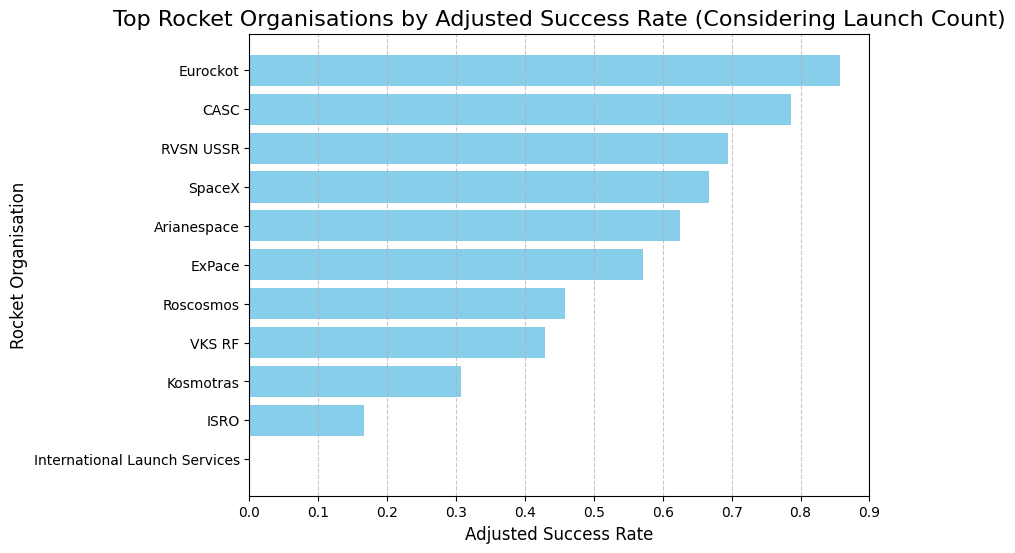

In [108]:
plt.figure(figsize=(8, 6))
plt.barh(success_rate.index, success_rate['Success Rate'], color='skyblue')
plt.gca().invert_yaxis() 
plt.title('Top Rocket Organisations by Adjusted Success Rate (Considering Launch Count)', fontsize=16)
plt.xlabel('Adjusted Success Rate', fontsize=12)
plt.ylabel('Rocket Organisation', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

The plot suggests that Eurockot is more likely to succeed: let's dive deeper.

In [109]:
# Create a contingency table
contingency_table = pd.crosstab(df_balanced['Rocket Organisation'], df_balanced['Success Binary'])

# Perform the test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.4f}, p-value: {p:.4f}")

# Interpret the results
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant relationship between rocket price and launch success.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.")

Chi-square statistic: 30.1258, p-value: 0.0027
Reject the null hypothesis: There is a significant relationship between rocket price and launch success.


To examine the relationship between corporation and launch success, we conducted a chi-square test. This test evaluates the independence of a feature (launch success: 0 or 1) from another (corporation). The results show:

- Chi-square statistic: 30.1258,
- P-value: 0.0027

With a p-value of 0.0027, which is exceptionally smaller than the conventional significance level of 0.05, we the null hypothesis is rejected, meaning that launch success is, in fact, dependent on the corporation.

The Chi-square statistic of 30.1258 points towards a very strong relationship between corporation and success. However, given the high p-value, this relationship is not statistically significant and is likely due to random chance rather than a true association in the population.

In conclusion, based on this chi-square test and the respective statistical value and P-value, we can conclude that organization has a meaningful influence on launch success.

We can, however, still try to figure out which company is more likely to succeed according to both raw success rate and to residual.

In [110]:
success_rate['Confidence Interval'] = success_rate.apply(
    lambda row: (
        row['Success Rate'] - 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
        row['Success Rate'] + 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
    ),
    axis=1
)

contingency_table = pd.crosstab(df_balanced['Rocket Organisation'], df_balanced['Success Binary'])

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

# Sort residuals
residuals = residuals.sum(axis=1).sort_values(ascending=False)
print(residuals)

Rocket Organisation
International Launch Services    0.364576
ISRO                             0.287455
Kosmotras                        0.283726
Roscosmos                        0.183193
VKS RF                           0.170445
ExPace                           0.016906
Arianespace                     -0.033186
SpaceX                          -0.059157
Starsem                         -0.111100
ULA                             -0.111100
Eurockot                        -0.190327
RVSN USSR                       -0.210950
CASC                            -0.277038
dtype: float64


Before concluding anything, however, we must reason about the meaning of a high or low, positive or negative residual. The residual looks to highlight, in this case, that an organization sucess is more or less likely to be due to randomness and not due to the organization itself. Besides that, we must also understand that confidence intervales are meant to evaluate how consistent a feature is (in this case, the organization).

After performing the calculation of confidence intervals for each organization, performing a chi-square test and calulating residuals for each enterprise, we understand that, if we are only taking into consideration raw success rate, Eurockot is a clear favorite succeed, as it holds a 95% success rate. However, if we are taking into account both the residuals and the confidence intervals, ILS comes across as the most consistent organization even while not keeping a higher success-rate. Looking at the following plot,Eurockot still takes the lead.

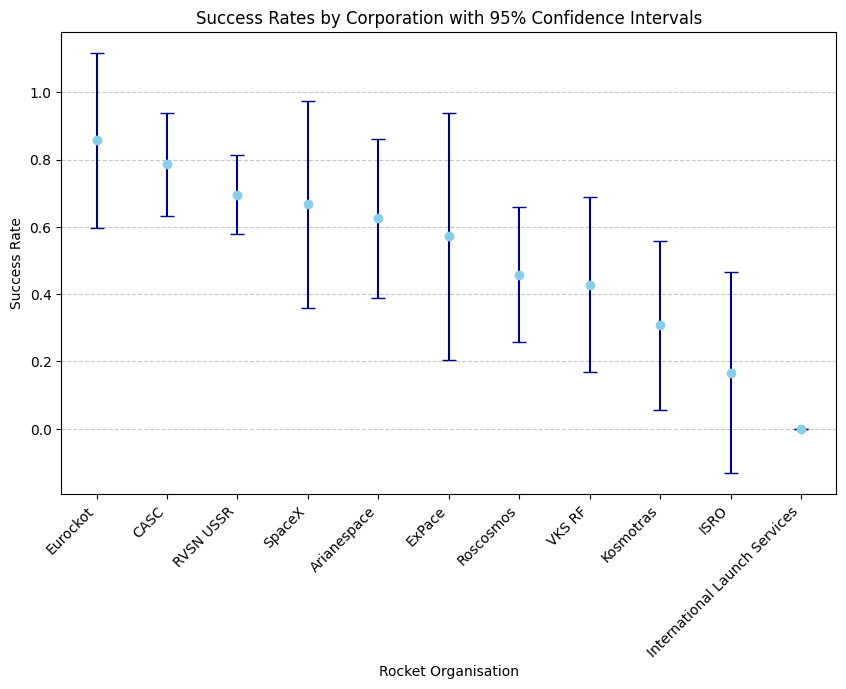

In [111]:
plt.figure(figsize=(10, 6))
plt.errorbar(
    success_rate.index,
    success_rate['Success Rate'],
    yerr=[
        success_rate['Success Rate'] - success_rate['Confidence Interval'].apply(lambda x: x[0]),
        success_rate['Confidence Interval'].apply(lambda x: x[1]) - success_rate['Success Rate']
    ],
    fmt='o', capsize=5, color='skyblue', ecolor='darkblue'
)
plt.title('Success Rates by Corporation with 95% Confidence Intervals')
plt.xlabel('Rocket Organisation')
plt.ylabel('Success Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Last but not least: is there any country more likely to succeed in a launch?

In [112]:
success_rate = (
    df_balanced.groupby('Country')['Success Binary']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={'count': 'Total Launches', 'sum': 'Successful Launches', 'mean': 'Success Rate'})
)

success_rate = success_rate[success_rate['Total Launches'] >= 5]

success_rate = success_rate.sort_values(by=['Success Rate', 'Total Launches'], ascending=[False, False])

success_rate.head()

,Total Launches,Successful Launches,Success Rate
Country,,,
China,35,26,0.742857
United States,10,7,0.700000
Russia,57,37,0.649123
French Guiana,16,10,0.625000
Kazakhstan,66,32,0.484848


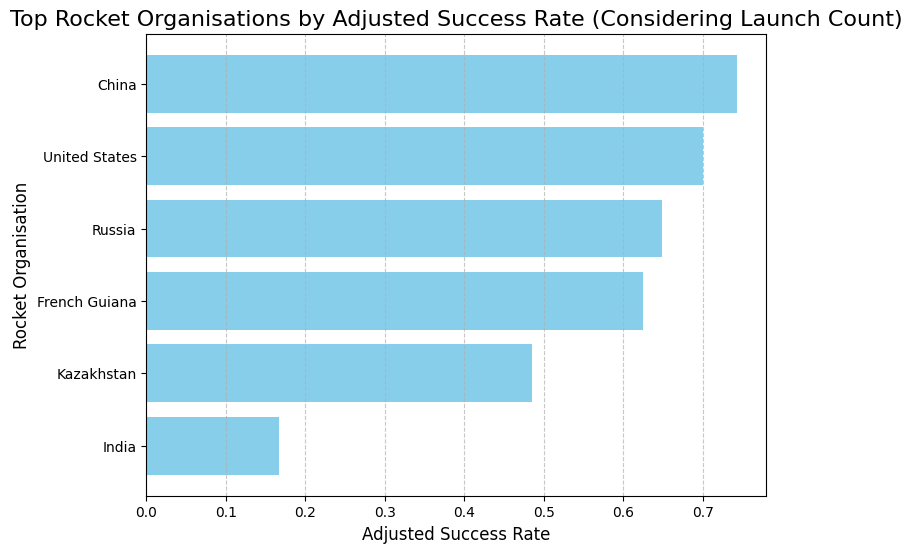

In [113]:
plt.figure(figsize=(8, 6))
plt.barh(success_rate.index, success_rate['Success Rate'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Top Rocket Organisations by Adjusted Success Rate (Considering Launch Count)', fontsize=16)
plt.xlabel('Adjusted Success Rate', fontsize=12)
plt.ylabel('Rocket Organisation', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [114]:
# Create a contingency table
contingency_table = pd.crosstab(df_balanced['Country'], df_balanced['Success Binary'])

# Perform the test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.4f}, p-value: {p:.4f}")

# Interpret the results
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: There is a significant relationship between rocket price and launch success.")
else:
    print("Fail to reject the null hypothesis: There is no significant relationship between rocket price and launch success.")

Chi-square statistic: 12.2742, p-value: 0.0312
Reject the null hypothesis: There is a significant relationship between rocket price and launch success.


In [117]:
success_rate['Confidence Interval'] = success_rate.apply(
    lambda row: (
        row['Success Rate'] - 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
        row['Success Rate'] + 1.96 * ((row['Success Rate'] * (1 - row['Success Rate'])) / row['Total Launches'])**0.5,
    ),
    axis=1
)

contingency_table = pd.crosstab(df_balanced['Country'], df_balanced['Success Binary'])

# Perform the Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculate residuals
residuals = (contingency_table - expected) / np.sqrt(expected)

# Sort residuals
residuals = residuals.sum(axis=1).sort_values(ascending=False)
print(residuals)

Country
India            0.287455
Kazakhstan       0.244738
French Guiana   -0.033186
United States   -0.091255
Russia          -0.112565
China           -0.240230
dtype: float64


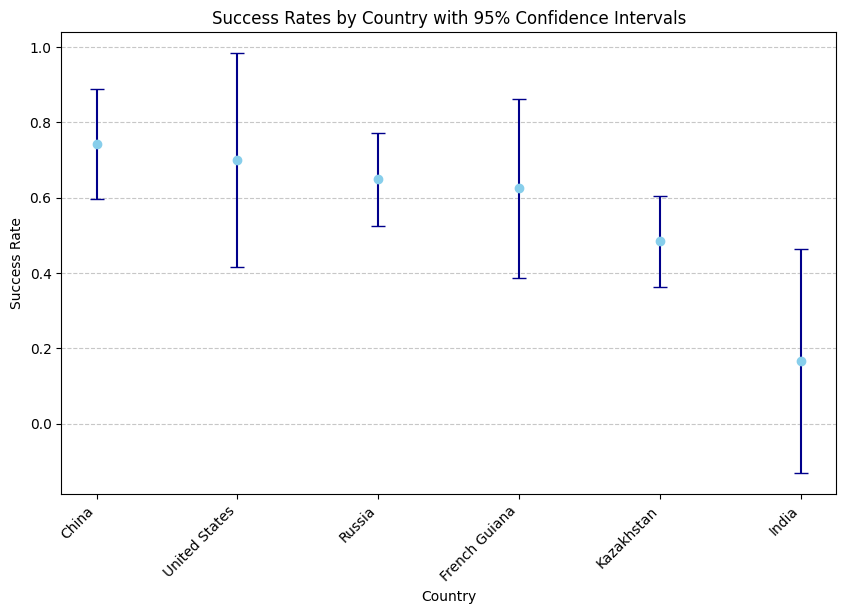

In [119]:
plt.figure(figsize=(10, 6))
plt.errorbar(
    success_rate.index,
    success_rate['Success Rate'],
    yerr=[
        success_rate['Success Rate'] - success_rate['Confidence Interval'].apply(lambda x: x[0]),
        success_rate['Confidence Interval'].apply(lambda x: x[1]) - success_rate['Success Rate']
    ],
    fmt='o', capsize=5, color='skyblue', ecolor='darkblue'
)
plt.title('Success Rates by Country with 95% Confidence Intervals')
plt.xlabel('Country')
plt.ylabel('Success Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
